In [160]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import warnings
from time import time

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

plt.rc('text', usetex=True)
    
from asap.stellar_mass_function import get_smf_bootstrap
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 
from asap.asap_model_prediction import asap_predict_mhalo 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the current best-fit model

In [4]:
test_dir = 'test'

model_str = 'asap_mmax_m10_frac4_test_B'

config_file = os.path.join(test_dir, model_str + '.yaml')

burnin_file = os.path.join(test_dir, model_str + '_burnin.npz')
result_file = os.path.join(test_dir, model_str + '_run.npz')

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

print(cfg['model_type'])

um_mock = um_data['um_mock']

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volu

In [5]:
um_mock

array([(8272347463,         -1, 4.383e+10, 2.421e+10,  13.66828 ,  17.07325 ,  15.77554 , 6.80400e+10, 6.80400000e+10, 10.64177147, 10.38399479, 10.8327643 , 10.8327643 , 12.08849047, 12.34517762, 12.08849047, 1.        , 0.64417989, 0.35582011),
       (8272347732,         -1, 9.008e+10, 8.309e+09,  15.00101 ,  17.807301,  17.26893 , 9.83890e+10, 1.50607498e+11, 10.95462838,  9.91954876, 10.99294655, 11.17784659, 12.42226145, 12.42226145, 12.42226145, 0.65328089, 0.9155495 , 0.0844505 ),
       (8272347735, 8272347732, 5.018e+10, 7.893e+08,  15.01558 ,  17.83338 ,  17.26683 , 5.09693e+10, 1.50607498e+11, 10.70053066,  8.8972421 , 10.70730867, 11.17784659, 11.45255306, 12.0136797 , 12.42226145, 0.33842472, 0.98451421, 0.01548579),
       ...,
       (8360214958,         -1, 1.940e+10, 5.654e+10, 385.971985, 396.552032, 391.503906, 7.59400e+10, 2.64180674e+11, 10.28780173, 10.7523558 , 10.88047059, 11.42190104, 13.16524433, 13.17318627, 13.16524433, 0.28745479, 0.25546484, 0.74453516),


In [7]:
print(len(um_mock), np.nanmin(um_mock['logmh_peak']), np.nanmin(um_mock['logmh_vir']))

(791807, 11.50023647482564, 8.753353212641496)


### Check the satellite fraction using the original UM catalog

In [46]:
mask_central = um_mock['upid'] == -1

um_cen = um_mock[mask_central]
um_sat = um_mock[~mask_central]

print("There are %d central galaxies" % len(um_cen))
print("There are %d satellite galaxies" % len(um_sat))

# Stellar mass bins: 
logms_bin = np.linspace(11.2, 12.4, 12)

# Indexing the catalog using in situ, ex situ, and total stellar mass
idx_logms_ins = np.digitize(um_mock['logms_gal'], logms_bin)
idx_logms_exs = np.digitize(um_mock['logms_icl'], logms_bin)
idx_logms_tot = np.digitize(um_mock['logms_tot'], logms_bin)

# Measure the satellite fraction
## In situ mass
frac_sat_ins = np.array([((len(um_mock[idx_logms_ins == k]) - np.sum(mask_central[idx_logms_ins == k])) * 1.0 /
                          (len(um_mock[idx_logms_ins == k])))
                         for k in (np.arange(len(logms_bin)) + 1)])
n_sat_ins = np.array([(len(um_mock[idx_logms_ins == k]) - np.sum(mask_central[idx_logms_ins == k]))
                      for k in (np.arange(len(logms_bin)) + 1)])
n_all_ins = np.array([(len(um_mock[idx_logms_ins == k])) for k in (np.arange(len(logms_bin)) + 1)])
frac_sat_ins_err = np.sqrt(n_sat_ins) / n_all_ins

## Ex situ mass
frac_sat_exs = np.array([((len(um_mock[idx_logms_exs == k]) - np.sum(mask_central[idx_logms_exs == k])) * 1.0 /
                          (len(um_mock[idx_logms_exs == k])))
                         for k in (np.arange(len(logms_bin)) + 1)]) 
n_sat_exs = np.array([(len(um_mock[idx_logms_exs == k]) - np.sum(mask_central[idx_logms_exs == k]))
                      for k in (np.arange(len(logms_bin)) + 1)])
n_all_exs = np.array([(len(um_mock[idx_logms_exs == k])) for k in (np.arange(len(logms_bin)) + 1)])
frac_sat_exs_err = np.sqrt(n_sat_exs) / n_all_exs

## Total stellar mass
frac_sat_tot = np.array([((len(um_mock[idx_logms_tot == k]) - np.sum(mask_central[idx_logms_tot == k])) * 1.0 /
                          (len(um_mock[idx_logms_tot == k])))
                         for k in (np.arange(len(logms_bin)) + 1)])
n_sat_tot = np.array([(len(um_mock[idx_logms_tot == k]) - np.sum(mask_central[idx_logms_tot == k]))
                      for k in (np.arange(len(logms_bin)) + 1)])
n_all_tot = np.array([(len(um_mock[idx_logms_tot == k])) for k in (np.arange(len(logms_bin)) + 1)])
frac_sat_tot_err = np.sqrt(n_sat_tot) / n_all_tot

# Mean in situ, ex situ, and total stellar mass in eac hbin
logms_mean_ins = [np.nanmean(um_mock['logms_gal'][idx_logms_ins == k]) for k in (np.arange(len(logms_bin)) + 1)]
logms_mean_exs = [np.nanmean(um_mock['logms_icl'][idx_logms_exs == k]) for k in (np.arange(len(logms_bin)) + 1)]
logms_mean_tot = [np.nanmean(um_mock['logms_tot'][idx_logms_tot == k]) for k in (np.arange(len(logms_bin)) + 1)]

There are 372240 central galaxies
There are 419567 satellite galaxies


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Text(0,0.5,'$\\mathrm{Number}$')

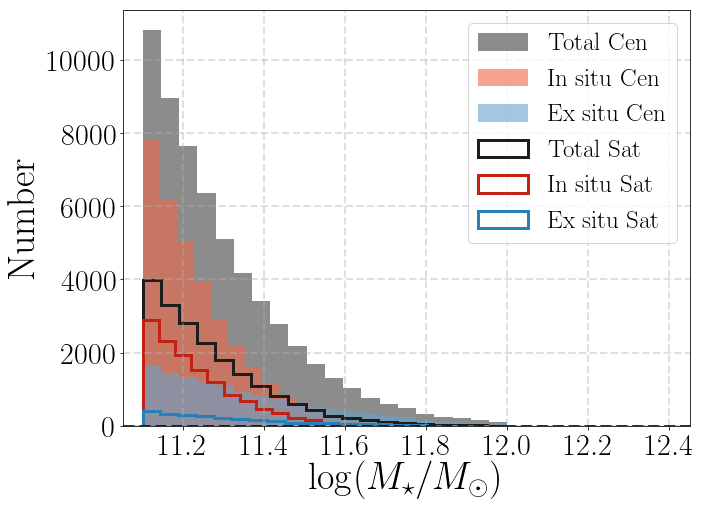

In [73]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.hist(um_cen['logms_tot'][(um_cen['logms_tot'] >= 11.1) & (um_cen['logms_tot'] <= 12.0)], 
         bins=20, histtype='stepfilled',
         alpha=0.6, color=BLK(0.8), label='$\mathrm{Total\ Cen}$')
    
ax1.hist(um_cen['logms_gal'][(um_cen['logms_gal'] >= 11.1) & (um_cen['logms_gal'] <= 12.0)], 
         bins=20, histtype='stepfilled',
         alpha=0.6, color=ORG(0.7), label='$\mathrm{In\ situ\ Cen}$')

ax1.hist(um_cen['logms_icl'][(um_cen['logms_icl'] >= 11.1) & (um_cen['logms_icl'] <= 12.0)], 
         bins=20, histtype='stepfilled',
         alpha=0.6, color=BLU(0.7), label='$\mathrm{Ex\ situ\ Cen}$')


ax1.hist(um_sat['logms_tot'][(um_sat['logms_tot'] >= 11.1) & (um_sat['logms_tot'] <= 12.0)], 
         bins=20, histtype='step', linewidth=3.0,
         alpha=1.0, color=BLK(0.9), label='$\mathrm{Total\ Sat}$')

ax1.hist(um_sat['logms_gal'][(um_sat['logms_gal'] >= 11.1) & (um_sat['logms_gal'] <= 12.0)], 
         bins=20, histtype='step', linewidth=3.0,
         alpha=1.0, color=ORG(0.9), label='$\mathrm{In\ situ\ Sat}$')

ax1.hist(um_sat['logms_icl'][(um_sat['logms_icl'] >= 11.1) & (um_sat['logms_icl'] <= 12.0)], 
         bins=20, histtype='step', linewidth=3.0,
         alpha=1.0, color=BLU(0.9), label='$\mathrm{Ex\ situ\ Sat}$')

ax1.legend(loc='upper right', fontsize=25)

ax1.set_xlim(11.051, 12.45)
#ax1.set_ylim(-0.08, 0.55)

ax1.axhline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

Text(0,0.5,'$\\mathrm{Fraction\\ of\\ Satellite}$')

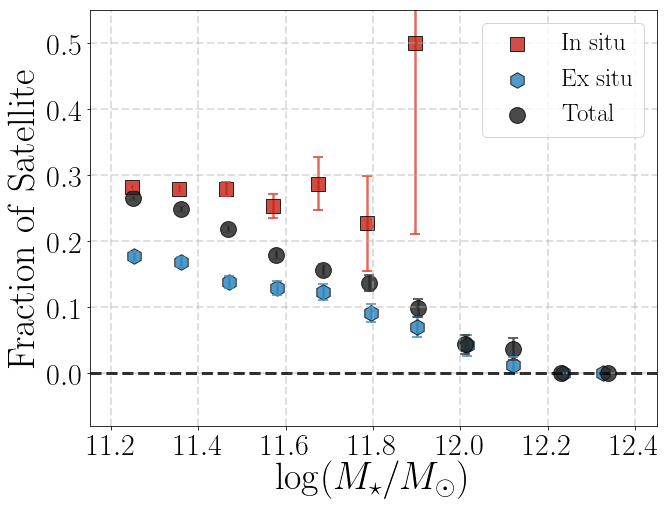

In [75]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)


ax1.errorbar(logms_mean_ins, frac_sat_ins, yerr=frac_sat_ins_err, 
             fmt='o', ecolor=ORG(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=ORG(0.8), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1, label='__no_label__')

ax1.errorbar(logms_mean_exs, frac_sat_exs, yerr=frac_sat_exs_err, 
             fmt='o', ecolor=BLU(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLU(0.8), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1, label='__no_label__')

ax1.errorbar(logms_mean_tot, frac_sat_tot, yerr=frac_sat_tot_err, 
             fmt='o', ecolor=BLK(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.8), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1, label='__no_label__')

ax1.scatter(logms_mean_ins, frac_sat_ins, c=ORG(0.9), marker='s',
            s=180, alpha=0.8, edgecolor='k', label='$\mathrm{In\ situ}$')

ax1.scatter(logms_mean_exs, frac_sat_exs, c=BLU(0.9), marker='h',
            s=240, alpha=0.8, edgecolor='k', label='$\mathrm{Ex\ situ}$')

ax1.scatter(logms_mean_tot, frac_sat_tot, c=BLK(0.9), 
            s=250, alpha=0.8, edgecolor='k', label='$\mathrm{Total}$')

ax1.legend(loc='upper right', fontsize=25)

ax1.set_xlim(11.151, 12.45)
ax1.set_ylim(-0.08, 0.55)

ax1.axhline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Fraction\ of\ Satellite}$', fontsize=38)

#fig.savefig(os.path.join('fig', model_str + '_frac_sat.pdf'), dpi=150)

#### Mass difference between central and satellites

In [159]:
def find_central(sat, catalog):
    """Find the central galaxy of the host halo."""
    mask_cen = (catalog['halo_id'] == sat['upid'])
    
    if mask_cen.sum() < 1:
        return -1 
        warnings.warn("No central found!")
    elif mask_cen.sum() > 1:
        raise Exception("Two centrals ?? No way")
    
    return catalog[mask_cen]['halo_id'][0]

In [92]:
massive_sat_1 = (um_sat['logms_tot'] >= 11.4)

print(massive_sat_1.sum())

mass_central = np.asarray([um_mock[um_mock['halo_id'] == find_central(sat, um_mock)]['logms_tot'][0]
                           for sat in um_sat[massive_sat_1]])

mhalo_central = np.asarray([um_mock[um_mock['halo_id'] == find_central(sat, um_mock)]['logmh_vir'][0]
                           for sat in um_sat[massive_sat_1]])

mpeak_central = np.asarray([um_mock[um_mock['halo_id'] == find_central(sat, um_mock)]['logmh_peak'][0]
                           for sat in um_sat[massive_sat_1]])

3170


In [95]:
mins_central = np.asarray([um_mock[um_mock['halo_id'] == find_central(sat, um_mock)]['logms_gal'][0]
                           for sat in um_sat[massive_sat_1]])

mexs_central = np.asarray([um_mock[um_mock['halo_id'] == find_central(sat, um_mock)]['logms_icl'][0]
                           for sat in um_sat[massive_sat_1]])

Text(0,0.5,'$\\mathrm{Number}$')

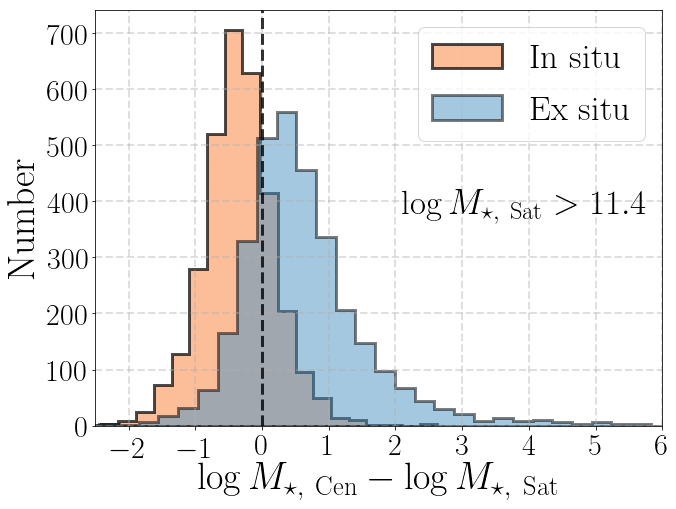

In [108]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.hist(mins_central - um_sat[massive_sat_1]['logms_gal'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.7, color=ORG(0.5), edgecolor=BLK(1.0), label=r'$\mathrm{In\ situ}$')

mask_use = np.isfinite(um_sat[massive_sat_1]['logms_icl'])
ax1.hist(mexs_central[mask_use] - um_sat[massive_sat_1][mask_use]['logms_icl'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.5, color=BLU(0.8), edgecolor=BLK(1.0), label=r'$\mathrm{Ex\ situ}$')

ax1.legend(loc='upper right', fontsize=35)

ax1.set_xlim(-2.5, 6.0)

ax1.axvline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.text(2.1, 370, r'$\log M_{\star,\ \mathrm{Sat}} > 11.4$', fontsize=35)

ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Cen}} - \log M_{\star,\ \mathrm{Sat}}$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

Text(0,0.5,'$\\mathrm{Number}$')

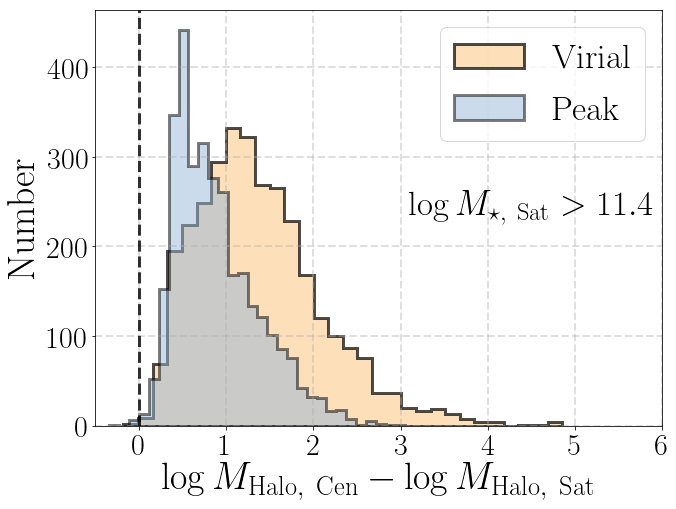

In [111]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.hist(mhalo_central - um_sat[massive_sat_1]['logmh_vir'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.7, color=ORG(0.3), edgecolor=BLK(1.0), label=r'$\mathrm{Virial}$')

ax1.hist(mpeak_central - um_sat[massive_sat_1]['logmh_peak'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.5, color=BLU(0.5), edgecolor=BLK(1.0), label=r'$\mathrm{Peak}$')

ax1.legend(loc='upper right', fontsize=35)

ax1.set_xlim(-0.5, 6.0)

ax1.axvline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.text(3.1, 230, r'$\log M_{\star,\ \mathrm{Sat}} > 11.4$', fontsize=35)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Cen}} - \log M_{\mathrm{Halo,\ Sat}}$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

Text(0,0.5,'$\\mathrm{Number}$')

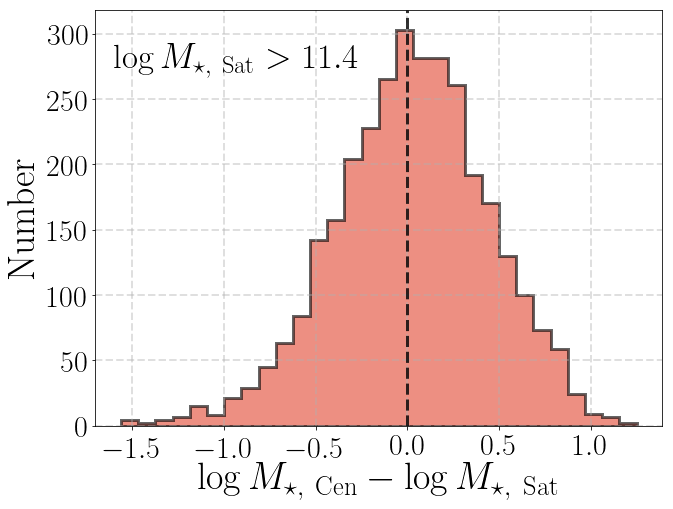

In [94]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.hist(mass_central - um_sat[massive_sat_1]['logms_tot'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.6, color=ORG(0.8), edgecolor=BLK(1.0))

ax1.axvline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.text(-1.6, 270, r'$\log M_{\star,\ \mathrm{Sat}} > 11.4$', fontsize=35)

ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Cen}} - \log M_{\star,\ \mathrm{Sat}}$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

### Evaluate the current best-fit model

In [166]:
(mod_burnin_samples, 
 mod_burnin_chains, 
 mod_burnin_lnprob, 
 mod_burnin_best, _, _) = mcmc_load_results(burnin_file)

(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = mcmc_load_results(result_file)

print(np.nanmax(mod_burnin_lnprob), mod_burnin_best)
print(np.nanmax(mod_result_lnprob), mod_result_best)

cfg['obs_min_mtot'] = 10.0

mod_model_prob = asap_predict_model_prob(mod_result_best, cfg, obs_data, um_data,  
                                         show_smf=False, show_dsigma=False, 
                                         return_all=True)

um_smf_tot, um_smf_inn, um_dsigma, logms_mod_inn, logms_mod_max, sig_logm, mask_tot = mod_model_prob

print(len(logms_mod_tot))

um_mock_use = um_mock[mask_tot]
mask_central_use = um_mock_use['upid'] == -1

(-260.0450291683457, array([ 6.16484320e-01,  3.50750764e+00, -3.59448857e-04,  1.84948497e-02,
        6.67085970e-01, -1.74311345e-01,  7.91683782e-02]))
(-260.3025836270948, array([ 6.16618459e-01,  3.50590999e+00, -6.76425385e-04,  1.67711988e-02,
        6.63645898e-01, -1.78583908e-01,  7.42752637e-02]))
441934


#### Save a new catalog with more galaxies

In [167]:
um_massive = Table(um_mock_use)

um_massive.add_column(Column(data=logms_mod_max, name='logms_max'))
um_massive.add_column(Column(data=logms_mod_inn, name='logms_10'))
um_massive.add_column(Column(data=sig_logm, name='sigma_logms'))

um_massive_cen = um_massive[um_massive['upid'] == -1]
um_massive_sat = um_massive[um_massive['upid'] != -1]
print(len(um_massive_cen), len(um_massive_sat))

(372110, 344640)


In [168]:
um_massive.write('um_ins_exs_logms_10.8_asap_180813.fits', format='fits', 
                 overwrite=True)

um_massive_cen.write('um_ins_exs_logms_10.8_cen_asap_180813.fits', format='fits', 
                     overwrite=True)

um_massive_sat.write('um_ins_exs_logms_10.8_sat_asap_180813.fits', format='fits', 
                     overwrite=True)

#### Look into the massive satellite population

In [169]:
um_massive = np.asarray(um_massive)

um_massive_cen = um_massive[um_massive['upid'] == -1]
um_massive_sat = um_massive[um_massive['upid'] != -1]

In [170]:
def find_central_mass(sat, catalog, mass_column):
    central = catalog[catalog['halo_id'] == find_central(sat, catalog)]
    if len(central) > 0:
        return central[0][mass_column]
    
    return np.nan

In [179]:
massive_cen_1 = (um_massive_cen['logms_max'] >= 11.4)

print(massive_cen_1.sum())

22084


In [171]:
massive_sat_1 = (um_massive_sat['logms_max'] >= 11.4)

print(massive_sat_1.sum())

logms_central = np.asarray([find_central_mass(sat, um_massive, 'logms_max') 
                            for sat in um_massive_sat[massive_sat_1]])

2669


In [174]:
logmh_vir_central = np.asarray([find_central_mass(sat, um_massive, 'logmh_vir') 
                                for sat in um_massive_sat[massive_sat_1]])

logmh_peak_central = np.asarray([find_central_mass(sat, um_massive, 'logmh_peak') 
                                 for sat in um_massive_sat[massive_sat_1]])

2665


Text(0,0.5,'$\\mathrm{Number}$')

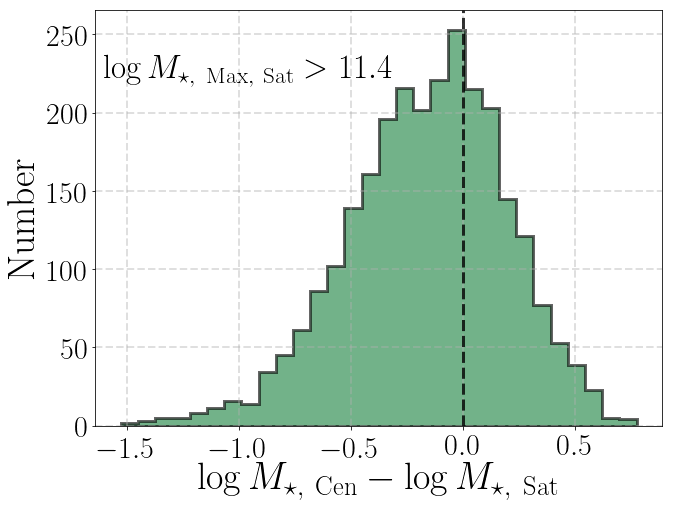

In [173]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

mask_use = np.isfinite(logms_central)
print(mask_use.sum())

ax1.hist(logms_central[mask_use] - um_massive_sat[massive_sat_1][mask_use]['logms_max'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.6, color=GRN(0.8), edgecolor=BLK(1.0))

ax1.axvline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.text(-1.6, 220, r'$\log M_{\star,\ \mathrm{Max,\ Sat}} > 11.4$', fontsize=33)

ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Cen}} - \log M_{\star,\ \mathrm{Sat}}$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

Text(0,0.5,'$\\mathrm{Number}$')

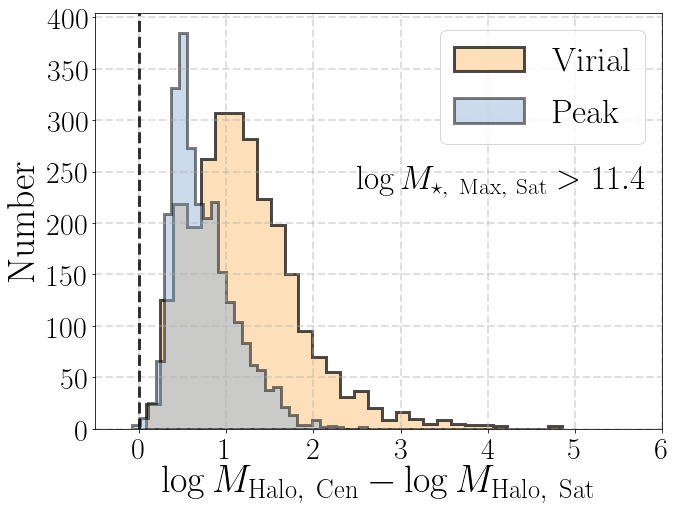

In [178]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.hist(logmh_vir_central[mask_use] - um_massive_sat[massive_sat_1][mask_use]['logmh_vir'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.7, color=ORG(0.3), edgecolor=BLK(1.0), label=r'$\mathrm{Virial}$')

ax1.hist(logmh_peak_central[mask_use] - um_massive_sat[massive_sat_1][mask_use]['logmh_peak'], 
         bins=30, histtype='stepfilled', linewidth=3.0,
         alpha=0.5, color=BLU(0.5), edgecolor=BLK(1.0), label=r'$\mathrm{Peak}$')

ax1.legend(loc='upper right', fontsize=35)

ax1.set_xlim(-0.5, 6.0)

ax1.axvline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.text(2.5, 230, r'$\log M_{\star,\ \mathrm{Max,\ Sat}} > 11.4$', fontsize=33)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Cen}} - \log M_{\mathrm{Halo,\ Sat}}$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Number}$', fontsize=38)

In [126]:
# Stellar mass bins: 
logms_bin = np.linspace(11.2, 12.2, 10)

# Indexing the catalog using predicted maximum 1-D stellar mass
idx_logms_max = np.digitize(logms_mod_max, logms_bin)

# Measure the satellite fraction
frac_sat_max = np.array([((len(um_mock_use[idx_logms_max == k]) - np.sum(mask_central_use[idx_logms_max == k])) * 1.0 /
                          (len(um_mock_use[idx_logms_max == k])))
                         for k in (np.arange(len(logms_bin)) + 1)])

n_sat_max = np.array([(len(um_mock_use[idx_logms_max == k]) - np.sum(mask_central_use[idx_logms_max == k]))
                      for k in (np.arange(len(logms_bin)) + 1)])

n_all_max = np.array([(len(um_mock_use[idx_logms_max == k])) for k in (np.arange(len(logms_bin)) + 1)])

frac_sat_max_err = np.sqrt(n_sat_max) / n_all_max

logms_mean_max = [np.nanmean(logms_mod_max[idx_logms_max == k]) for k in (np.arange(len(logms_bin)) + 1)]

Text(0,0.5,'$\\mathrm{Fraction\\ of\\ Satellite}$')

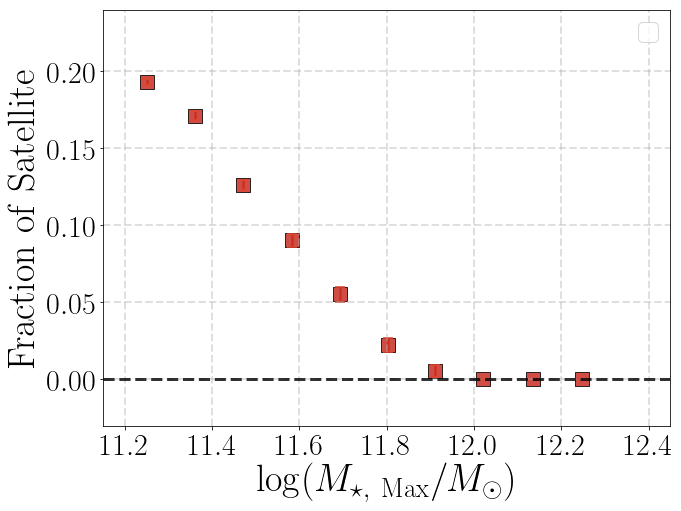

In [129]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)


ax1.errorbar(logms_mean_max, frac_sat_max, yerr=frac_sat_max_err, 
             fmt='o', ecolor=ORG(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=ORG(0.8), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1, label='__no_label__')

ax1.scatter(logms_mean_max, frac_sat_max, c=ORG(0.9), marker='s',
            s=180, alpha=0.8, edgecolor='k')

ax1.legend(loc='upper right', fontsize=25)

ax1.set_xlim(11.151, 12.45)
ax1.set_ylim(-0.03, 0.24)

ax1.axhline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=38)
ax1.set_ylabel(r'$\mathrm{Fraction\ of\ Satellite}$', fontsize=38)

#fig.savefig(os.path.join('fig', model_str + '_frac_sat.pdf'), dpi=150)